In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pickle as pkl
import torch

import data

from torch.utils.data import DataLoader

plt.rcParams['image.cmap'] = 'Blues_r'

In [5]:
batch_size = 10

In [6]:
from ultralytics import YOLO
from ultralytics.yolo.v8.detect.train import DetectionTrainer
from ultralytics.yolo.data.dataloaders.v5loader import create_dataloader
from ultralytics.yolo.v8.detect.train import Loss
import cv2
import torch
import matplotlib.pyplot as plt
import resize_right
import numpy as np

# load detection trainer using the weights best.pt
# best.pt is the custom model trained on YOLO_data_je
trainer = DetectionTrainer('args_digits_data_ver1.yaml')
trainer.setup_model()
trainer.model.double()
trainer.set_model_attributes()

Ultralytics YOLOv8.0.86 🚀 Python-3.9.16 torch-2.0.0 CPU
yolo/engine/trainer: task=detect, mode=predict, model=model_results/model_digit_data_ver1_256/weights/best.pt, data=detection_data.yaml, epochs=100, patience=50, batch=32, imgsz=256, save=True, save_period=-1, cache=False, device=None, workers=4, project=None, name=None, exist_ok=False, pretrained=False, optimizer=Adam, verbose=True, seed=0, deterministic=True, single_cls=False, image_weights=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, hide_labels=False, hide_conf=False, vid_stride=1, line_thickness=3, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchscript, keras=False, optimize=False, int8=False, d

In [7]:
# create dataset
dataset = data.GANs_Dataset()
dataset_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

10000
tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]], dtype=torch.float64)


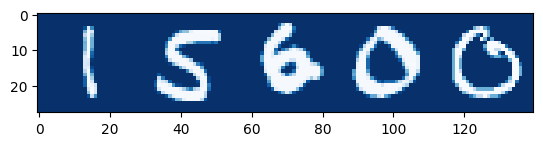

In [8]:
print(len(dataset))
print(dataset.image_list[0])
plt.imshow(dataset.image_list[0][0].numpy())
plt.show()

In [74]:
for batch_id, (images, classes, annotations) in enumerate(dataset_loader):
    images.requires_grad = True
    
    images = images.double()
    classes = classes.double()
    annotations = annotations.double()

    tensor_img = images.repeat(1, 3, 1, 1)
    classes = torch.flatten(classes, end_dim=1)
    annotations = torch.flatten(annotations, end_dim=1)

    batch_idx = []
    keep_indices = []
    batch_i = 0
    for i, cls in enumerate(classes):
        if cls.item() != -1:
            keep_indices.append(i)
            batch_idx.append(batch_i)

        if (cls.item() == -1 and batch_idx[-1] == batch_i) or (i + 1) % 5 == 0:
            batch_i += 1

    classes = classes[keep_indices]
    for i in range(len(classes)):
        classes[i] = 8 #(classes[i] + 1) % 10
    annotations = annotations[keep_indices]
    batch_idx = torch.tensor(batch_idx)

    tensor_img_resized = resize_right.resize(tensor_img, out_shape=(batch_size,3,256,256))
    batch = {'ori_shape': ((3, 256, 256) for _ in range(batch_size)),
        'ratio_pad': None,
        'im_file': None,
        'img': tensor_img_resized,
        'cls': classes,
        'bboxes': annotations,
        'batch_idx': batch_idx
    }

    yolo_out = trainer.model(tensor_img_resized)
    loss_fn = Loss(trainer.model)
    loss_adv, _ = loss_fn(yolo_out, batch)
    loss_adv *= -1 / batch_size
    
    loss_adv.backward()
    
    break

In [75]:
# for batch_id, (images, classes, annotations) in enumerate(dataset_loader):
#     images.requires_grad = True
    
#     images = images.double()
#     classes = classes.double()
#     annotations = annotations.double()

#     tensor_img = images.repeat(1, 3, 1, 1)
#     classes = torch.flatten(classes, end_dim=1)
#     annotations = torch.flatten(annotations, end_dim=1)

#     batch_idx = []
#     keep_indices = []
#     batch_i = 0
#     for i, cls in enumerate(classes):
#         if cls.item() != -1:
#             keep_indices.append(i)
#             batch_idx.append(batch_i)

#         if (cls.item() == -1 and batch_idx[-1] == batch_i) or (i + 1) % 5 == 0:
#             batch_i += 1

#     classes = classes[keep_indices]
#     annotations = annotations[keep_indices]
#     batch_idx = torch.tensor(batch_idx)

#     tensor_img_resized = resize_right.resize(tensor_img, out_shape=(batch_size,3,256,256))
#     batch = {'ori_shape': ((3, 256, 256) for _ in range(batch_size)),
#         'ratio_pad': None,
#         'im_file': None,
#         'img': tensor_img_resized,
#         'cls': torch.tensor([]),
#         'bboxes': torch.tensor([]),
#         'batch_idx': torch.tensor([])
#     }

#     yolo_out = trainer.model(tensor_img_resized)
#     loss_fn = Loss(trainer.model)
#     loss_adv, _ = loss_fn(yolo_out, batch)
#     loss_adv *= -1 / batch_size
    
#     loss_adv.backward()
    
#     break

In [76]:
def fgsm(images, epsilon):
    sign_grad = images.grad.sign()
    images_perturbed = images + epsilon * sign_grad
    images_perturbed = torch.clamp(images_perturbed, 0, 1)
    return images_perturbed

In [77]:
images_perturbed = fgsm(images, 0.02)

original image


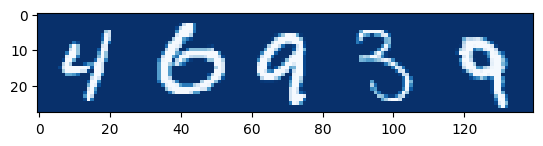

perturbed image


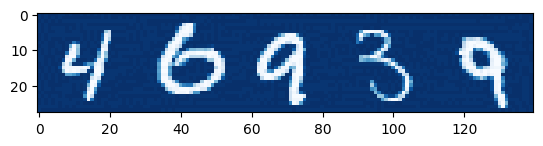

In [78]:
print('original image')
plt.imshow(images[0][0].detach())
plt.show()

print('perturbed image')
plt.imshow(images_perturbed[0][0].detach())
plt.show()

In [85]:
epsilon = 0.15

In [86]:
import os
os.mkdir(f'fgsm_sample_perturbed_images_{epsilon}_targ')

original


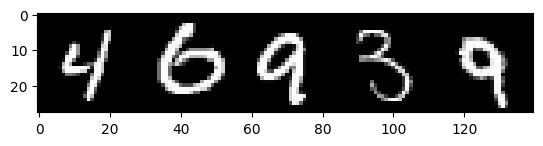

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


perturbation


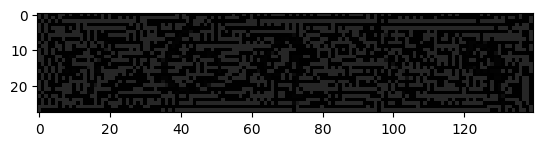

perturbed image


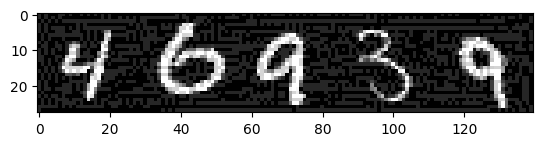

original


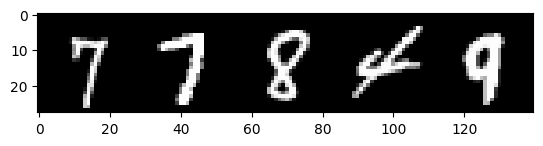

perturbation


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


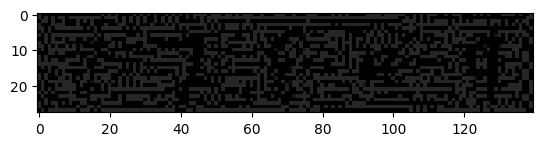

perturbed image


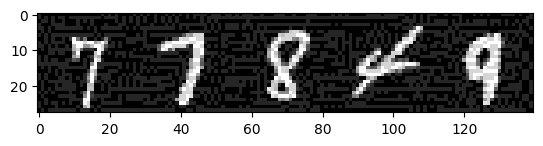

original


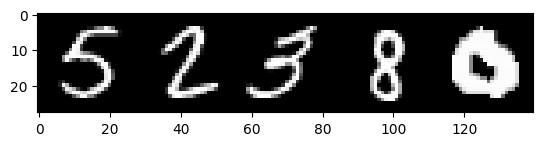

perturbation


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


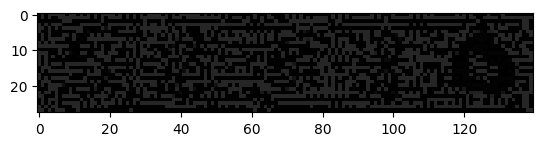

perturbed image


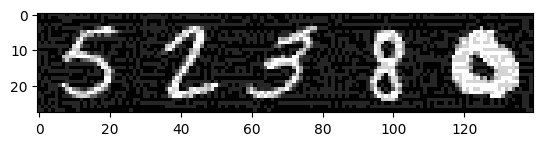

original


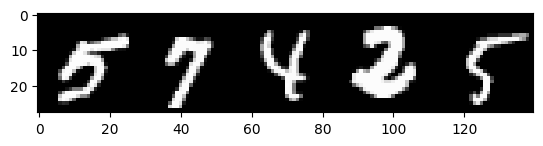

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


perturbation


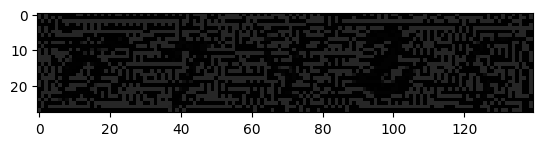

perturbed image


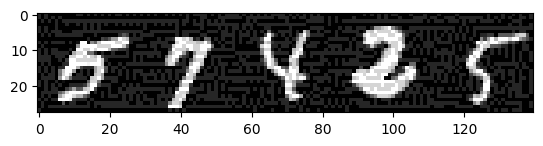

original


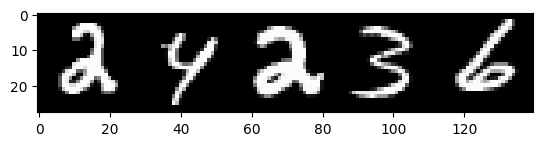

perturbation


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


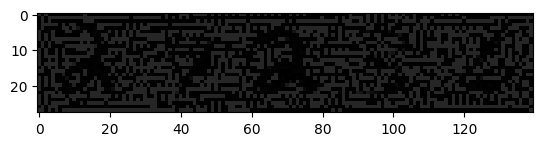

perturbed image


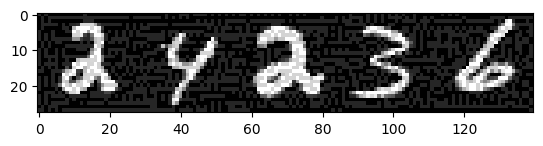

original


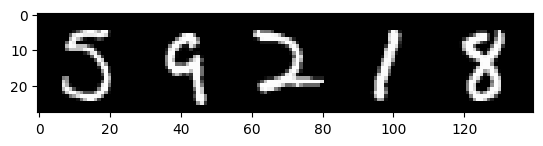

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


perturbation


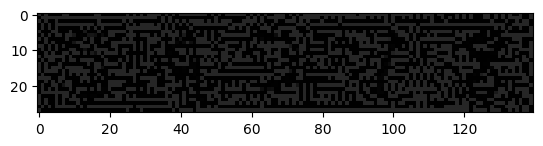

perturbed image


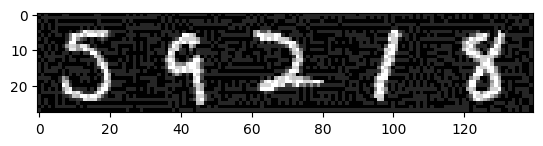

original


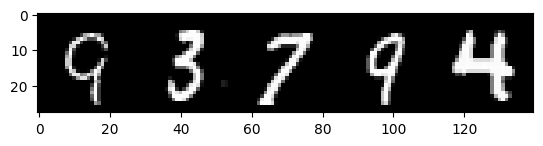

perturbation


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


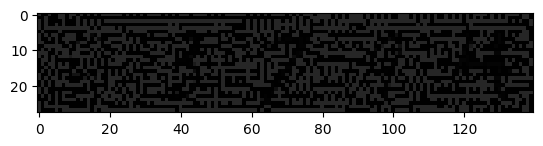

perturbed image


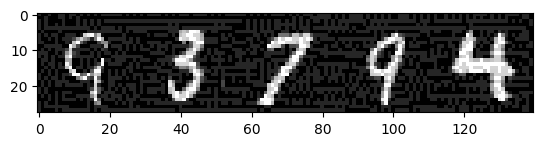

original


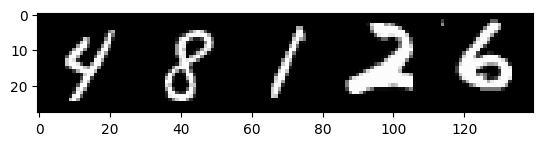

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


perturbation


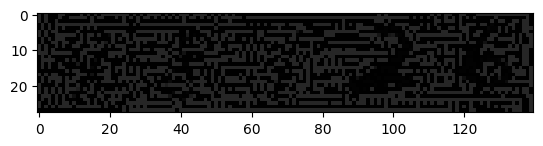

perturbed image


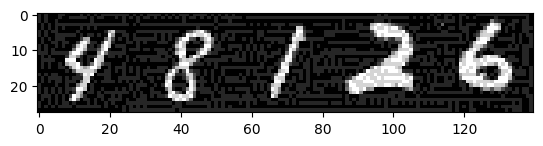

original


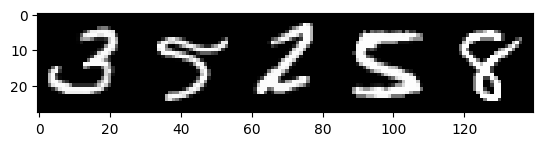

perturbation


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


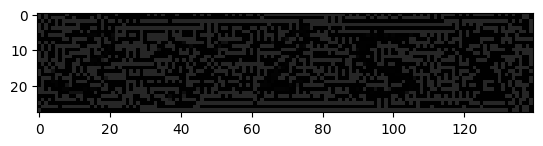

perturbed image


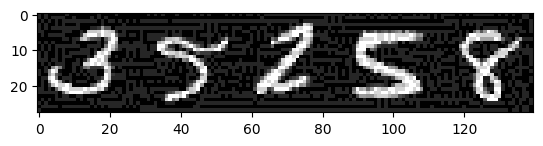

original


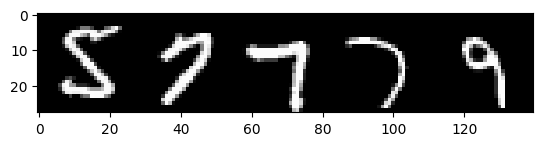

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


perturbation


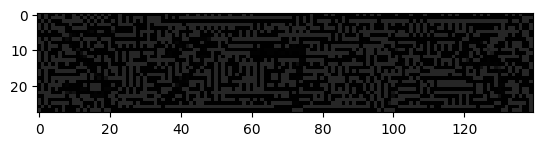

perturbed image


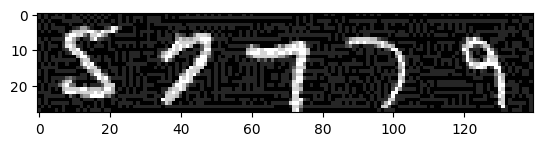

In [87]:
from torchvision.utils import save_image

tensor_img = images.repeat(1, 3, 1, 1)
x_perturbed = fgsm(images, epsilon)
x_perturbed = x_perturbed.repeat(1, 3, 1, 1)
perturb = x_perturbed - tensor_img

tensor_img = tensor_img.permute(0, 2, 3, 1)
perturb = perturb.permute(0, 2, 3, 1)
x_perturbed = x_perturbed.permute(0, 2, 3, 1)
    
for i in range(len(images)):
    print('original')
    plt.imshow(tensor_img[i].detach())
    plt.show()
    print('perturbation')
    plt.imshow(perturb[i].detach())
    plt.show()
    print('perturbed image')
    plt.imshow(x_perturbed[i].detach())
    plt.show()
    
    save_image(tensor_img[i].permute(2, 0, 1), f'fgsm_sample_perturbed_images_{epsilon}_targ/original_{i}.png')
    save_image(perturb[i].permute(2, 0, 1), f'fgsm_sample_perturbed_images_{epsilon}_targ/perturbation_{i}.png')
    save_image(x_perturbed[i].permute(2, 0, 1), f'fgsm_sample_perturbed_images_{epsilon}_targ/perturbed_{i}.png')